## Import libraries

In [70]:
import warnings
warnings.filterwarnings("ignore")
import keras
from keras.models import Model,load_model
from keras import Input
from keras.layers import concatenate,Dense,Flatten,Dropout
from keras.preprocessing.image import  ImageDataGenerator
import keras.callbacks as kcallbacks
import os
import math
import time
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import SGD
import operator
import numpy as np
from PIL import Image
from collections import defaultdict
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from io import StringIO
import pandas as pd

In [71]:
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
import shutil
from sklearn.preprocessing import QuantileTransformer
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.layers import Reshape

In [72]:
import os
from keras.preprocessing.image import  ImageDataGenerator
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,Dropout
from keras.models import Model,load_model,Sequential
from keras.applications.xception import  Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
# from keras.applications.resnet50 import  ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
import keras.callbacks as kcallbacks
import keras
# from keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf
from keras.utils import plot_model
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from PIL import Image
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import classification_report, confusion_matrix


## Read the test set

In [73]:
#generate images from train set and validation set
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128

test_datagen = ImageDataGenerator(rescale=1./255)


validation_generator = test_datagen.flow_from_directory(
        './target/test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 304 images belonging to 2 classes.


In [74]:
#generate labels indicating disease (1) or normal (0)
label=validation_generator.class_indices
label={v: k for k, v in label.items()}

In [75]:
print(label)

{0: '0', 1: '1'}


In [76]:
#read images from validation folder
rootdir = './target/test_224/'
test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))
        
print(test_laels[3],test_images[0])

0 ./target/test_224/0/28924.png


In [78]:
set(list(test_laels))

{'0', '1'}

## Load  trained models (CNN & LSTM)

In [79]:
#load model 3: Hybrid
hybrid_scratch_model=load_model('source_cnn_lstm_hybrid_final_model.h5')

# Concatenation

In [80]:
for i,layer in enumerate(hybrid_scratch_model.layers):
    print(i,layer.name)

0 input_2
1 conv2d_2
2 max_pooling2d_1
3 conv2d_3
4 dropout_2
5 global_average_pooling2d_1
6 reshape_1
7 lstm_1
8 dropout_3
9 dense_1


### Construct the ensemble model using the last "dense layer" of each base CNN model

In [81]:
model1=Model(inputs=[hybrid_scratch_model.layers[0].get_input_at(0)],outputs=hybrid_scratch_model.get_layer('dense_1').output,name='hybrid_model')

In [82]:
#plot the figures
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [83]:
ensemble_history= LossHistory()

In [84]:
#generate training and test images
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128	#could try 128 or 32

#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './target/train_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        './target/test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 1205 images belonging to 2 classes.
Found 304 images belonging to 2 classes.


In [85]:
def lr_decay(epoch):
    lrs = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0001,0.00001,0.000001,
           0.000001,0.000001,0.000001,0.000001,0.0000001,0.0000001,0.0000001,0.0000001,0.0000001,0.0000001
          ]
    return lrs[epoch]

In [86]:
auto_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
my_lr = LearningRateScheduler(lr_decay)

In [87]:
def ensemble(num_class,epochs):
    img=Input(shape=(224,224,3),name='img')
    feature1=model1(img)
#     x=concatenate([feature1])
    x=feature1
    x=Dropout(0.5)(x)
    x=Dense(64,activation='relu')(x)
    x=Dropout(0.5)(x)
    output=Dense(num_class,activation='softmax',name='output')(x)
    model=Model(inputs=img,outputs=output)
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_loss',patience=1, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath='./model', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
    ensemble_hist=model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[earlyStopping,saveBestModel,ensemble_history,auto_lr],

    )
    model.save("more_try_percentage_target_ensemble_transfer_learning_implemented.h5")
    return ensemble_hist


In [88]:
ensemble_hist=ensemble(num_class=2,epochs=10)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.6516 - accuracy: 0.7793
Epoch 1: val_accuracy improved from -inf to 0.84211, saving model to ./model


INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


10/10 [==============================] - 41s 4s/step - loss: 0.6516 - accuracy: 0.7793 - val_loss: 0.5958 - val_accuracy: 0.8421 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.5727 - accuracy: 0.8556
Epoch 2: val_accuracy did not improve from 0.84211
10/10 [==============================] - 39s 4s/step - loss: 0.5727 - accuracy: 0.8556 - val_loss: 0.5020 - val_accuracy: 0.8421 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.4936 - accuracy: 0.8954
Epoch 3: val_accuracy improved from 0.84211 to 0.98355, saving model to ./model


INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


10/10 [==============================] - 42s 4s/step - loss: 0.4936 - accuracy: 0.8954 - val_loss: 0.4323 - val_accuracy: 0.9836 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.4362 - accuracy: 0.9245
Epoch 4: val_accuracy did not improve from 0.98355
10/10 [==============================] - 44s 4s/step - loss: 0.4362 - accuracy: 0.9245 - val_loss: 0.3770 - val_accuracy: 0.9836 - lr: 0.0010
Epoch 5/10
10/10 [==============================] - ETA: 0s - loss: 0.3935 - accuracy: 0.9195
Epoch 5: val_accuracy did not improve from 0.98355
10/10 [==============================] - 45s 5s/step - loss: 0.3935 - accuracy: 0.9195 - val_loss: 0.3326 - val_accuracy: 0.9836 - lr: 0.0010
Epoch 6/10
10/10 [==============================] - ETA: 0s - loss: 0.3611 - accuracy: 0.9145
Epoch 6: val_accuracy did not improve from 0.98355
10/10 [==============================] - 45s 5s/step - loss: 0.3611 - accuracy: 0.9145 - val_loss: 0.2982 - val_accuracy: 0.9836 - lr: 0.00

In [89]:
hybrid_accuracy_t = ensemble_hist.history['accuracy'][-1]
hybrid_loss_t = ensemble_hist.history['loss'][-1]
hybrid_val_accuracy_t=  ensemble_hist.history['val_accuracy'][-1]
hybrid_val_loss_t = ensemble_hist.history['val_loss'][-1]
print("Accucacy:",round((hybrid_accuracy_t * 100),2),"%")
print("Loss:",round((hybrid_loss_t * 100),2),"%")
print("Val_Accucacy:",round((hybrid_val_accuracy_t * 100),2),"%")
print("Val_Loss:",round((hybrid_val_loss_t * 100),2),"%")

Accucacy: 93.2 %
Loss: 27.61 %
Val_Accucacy: 98.36 %
Val_Loss: 21.51 %


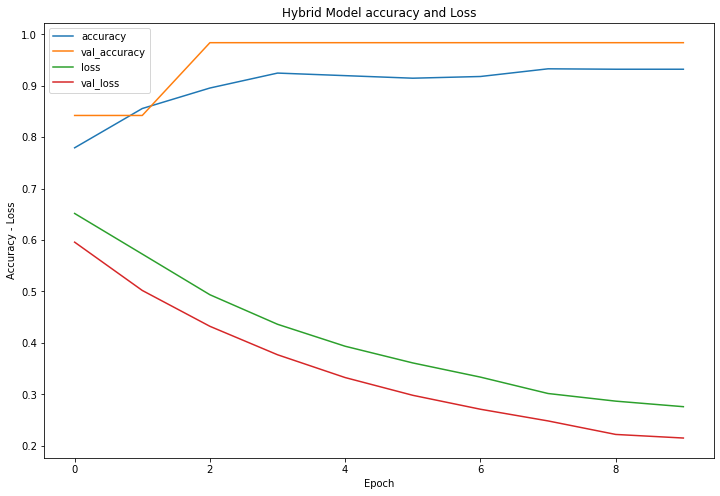

In [90]:
# Train and validation accuracy - loss
plt.figure(figsize=(12,8))
plt.plot(ensemble_hist.history['accuracy'])
plt.plot(ensemble_hist.history['val_accuracy'])
plt.plot(ensemble_hist.history['loss'])
plt.plot(ensemble_hist.history['val_loss'])
plt.title('Hybrid Model accuracy and Loss')
plt.ylabel('Accuracy - Loss')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy','loss', 'val_loss'])
plt.show()

In [50]:
ensemble_model=load_model('more_try_percentage_target_ensemble_transfer_learning_implemented.h5')

In [51]:
#read images from validation folder
rootdir = './target/test_224/'
test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))
        
print(test_laels[0],test_images[0])

0 ./target/test_224/0/28924.png


In [52]:
#test the averaging model on the validation set
import time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range((length//127)+1):
    inputimg=test_images[127*i:127*(i+1)]
    test_batch=[]
    for path in inputimg:
        thisimg=np.array(Image.open(path))/255
        test_batch.append(thisimg)
    #print(i, np.array(test_batch).shape)
    ensemble_model_batch=ensemble_model.predict(np.array(test_batch))
    predict_batch=list(np.argmax(ensemble_model_batch,axis=1))
    predict_batch=[label[con] for con in predict_batch]
    predict.append(predict_batch)

predict=sum(predict,[])

t2 = time.time()
print('The testing time is :%f seconds' % (t2-t1))

2/2 [==============================] - 0s 128ms/step
The testing time is :3.150831 seconds


In [53]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
print('After Transfered Learning accuracy:%s'%acc)

After Transfered Learning accuracy:0.9835526315789473


In [54]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('Hybrid TF target model accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1']
print(classification_report(test_laels, predict, target_names=target_names))

Hybrid TF target model accuracy: 0.9835526315789473
precision: 0.9838677152651742
recall: 0.9835526315789473
f1: 0.9831803135274579
[[256   0]
 [  5  43]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       256
           1       1.00      0.90      0.95        48

    accuracy                           0.98       304
   macro avg       0.99      0.95      0.97       304
weighted avg       0.98      0.98      0.98       304



Text(0.5, 1.0, 'Confusion matrix of hybrid model of TF by Concatenation ')

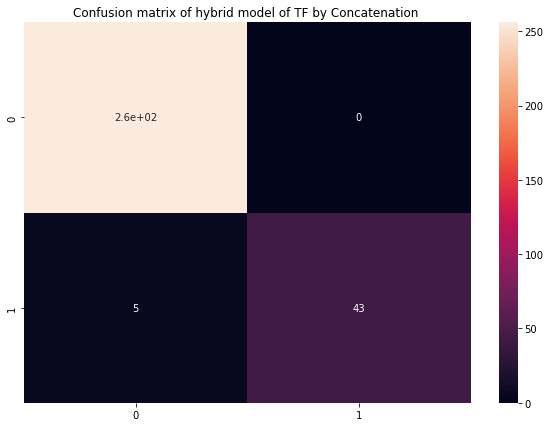

In [55]:
plt.figure(figsize=(10,7))
cf_matrix = confusion_matrix(test_laels, predict)
cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='.3f')
ax.set_title("Confusion matrix of hybrid model of TF by Concatenation ")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

# Roc Curve

In [ ]:
y_pred = predict  # predicted probabilities for each class
y_true = test_laels  # true labels for the test data

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# convert y_true and y_predicted to binary arrays
y_true_binary = [int(label) > 0 for label in y_true]
y_predicted_binary = [int(label) > 0 for label in y_pred]

# calculate TPR and FPR
fpr, tpr, thresholds = roc_curve(y_true_binary, y_predicted_binary)

# calculate AUC
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# Box plot, Detection rate, False alarm rate

In [ ]:
from keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Flatten

img=Input(shape=(224,224,3),name='img')
feature1=model1(img)
x=feature1
x=Dropout(0.5)(x)
x=Dense(64,activation='relu')(x)
x=Dropout(0.5)(x)
output=Dense(2,activation='softmax',name='output')(x)
model=Model(inputs=img,outputs=output)
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Train the model
normal_false_alarm_rate = []
fuzzy_false_alarm_rate = []

normal_detection_rate = []
fuzzy_detection_rate = []
for epoch in range(10):
    model.fit(train_generator,steps_per_epoch=len(train_generator),
              epochs=1,validation_data=validation_generator,
              validation_steps=len(validation_generator),
        )
    predict=[]
    length=len(test_images)
    t1 = time.time()
    for i in range(length):
        inputimg=test_images[i]
        test_batch=[]
        thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
        #print(thisimg)
        test_shape=(1,)+thisimg.shape
        thisimg=thisimg.reshape(test_shape)
        model_batch=model.predict(thisimg) #use master model to process the input image
        #generate result by model 1
        prob=model_batch[0,np.argmax(model_batch,axis=1)[0]]
        res=label[np.argmax(model_batch,axis=1)[0]]
        predict.append(res)
        
    cf_matrix = confusion_matrix(test_laels, predict)
    tp_0 = cf_matrix[0][0]
    tp_1 = cf_matrix[1][1]

    target_names = ['0', '1']
    report = classification_report(test_laels, predict, target_names=target_names)
    df = pd.read_fwf(StringIO(report), index_col=0)
    support_0 = df.iloc[0]['support']
    support_1 = df.iloc[1]['support']

    total_sum_of_diagonal = tp_0 + tp_1 
    fa_r0 = support_0 - tp_0
    fa_r1 = support_1 - tp_1


    normal_false_alarm_rate.append(fa_r0 / (fa_r0 + total_sum_of_diagonal - tp_0))
    fuzzy_false_alarm_rate.append(fa_r1 / (fa_r1 + total_sum_of_diagonal - tp_1))

    normal_detection_rate.append(tp_0 / support_0)
    fuzzy_detection_rate.append(tp_1 / support_1)


# Box plot for Hybrid TF model

In [ ]:
import seaborn as sns
import pandas as pd
plt.figure(figsize=(12,8))
# Sample detection rates for each class
data = {'Normal':normal_detection_rate, 'fuzzy':fuzzy_detection_rate}
df = pd.DataFrame(data)
sns.boxplot(data=df)
plt.title("Box Plot for the detection rate using HYBRID TF model ")
plt.show()

# Detection rate vs Epochs of Hybrid TF model

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
epochs_count = [i for i in range(1,len(fuzzy_detection_rate) + 1)]

plt.plot(epochs_count, normal_detection_rate, label='Normal')
plt.plot(epochs_count, fuzzy_detection_rate, label='fuzzy')

plt.xlabel('Epochs')
plt.ylabel('Detection Rate')
plt.title("Detection rate vs Epochs of HYBRID TF model")
plt.legend()
plt.show()

# False Alarm rate vs Epochs of Hybrid TF model

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
epochs_count = [i for i in range(1,len(fuzzy_false_alarm_rate) + 1)]

plt.plot(epochs_count, normal_detection_rate, label='Normal')
plt.plot(epochs_count, fuzzy_false_alarm_rate, label='fuzzy')

plt.xlabel('Epochs')
plt.ylabel('False Alarm Rate')
plt.title("False Alarm Rate vs Epochs of HYBRID TF model")
plt.legend()
plt.show()